<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [2]:
from google.colab import files
uploaded = files.upload()


import pandas as pd
from PIL import Image
from torchvision import transforms
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

Saving dev_df_images.json to dev_df_images.json
Saving train_df_images.json to train_df_images.json


In [12]:
train_df_images = pd.read_json('train_df_images.json', orient="records", lines=True)
dev_df_images = pd.read_json('dev_df_images.json', orient="records", lines=True)

In [13]:
train_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,"[[[85, 93, 69], [64, 70, 47], [50, 55, 39], [1..."
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,"[[[33, 31, 17], [35, 33, 19], [32, 31, 19], [2..."
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,"[[[109, 110, 103], [113, 115, 107], [117, 118,..."
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,"[[[136, 91, 41], [123, 74, 26], [169, 134, 89]..."
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,"[[[106, 88, 76], [114, 96, 84], [115, 96, 84],..."


In [14]:
dev_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,None
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,"[[[56, 122, 50], [116, 145, 94], [126, 154, 98..."
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,"[[[107, 141, 154], [86, 122, 134], [74, 106, 1..."
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"[[[45, 45, 45], [64, 64, 64], [43, 43, 43], [4..."


Mapping labels to integers

In [15]:
labels = train_df_images['label'].unique()
dict_mapping ={}

for i, label in enumerate(labels):
  dict_mapping[label]=int(i)
  i = i+1

print(dict_mapping)

for df in [train_df_images, dev_df_images]:
  df['label'] = df['label'].map(dict_mapping)
  df['label'] = df['label'].apply(lambda x: np.array(x))

{'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2, 'cultural': 3, 'cult': 4, None: 5, 'cultural agn': 6, 'cultural represent': 7, 'cultural ex': 8, 'cultural ag': 9}


In [16]:
train_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,0,"[[[85, 93, 69], [64, 70, 47], [50, 55, 39], [1..."
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,1,"[[[33, 31, 17], [35, 33, 19], [32, 31, 19], [2..."
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,1,"[[[109, 110, 103], [113, 115, 107], [117, 118,..."
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,1,"[[[136, 91, 41], [123, 74, 26], [169, 134, 89]..."
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,1,"[[[106, 88, 76], [114, 96, 84], [115, 96, 84],..."


## Fill in or drop

Some photos are missing for many items, and as the CNN can not handles missing values, we have to find solutions to deal with this problem. We have for now 2 options :

- Fill in the NaN with white images
- Drop the item with missing image

In [17]:
def fill_NaN_image(image):

  """
  If a cell is empty, it fills in with a white image, of dimension (28,28,3) ie (height, width, channels)
  """

  if image is None or (isinstance(image, float) and np.isnan(image)):
    image = np.ones((28, 28, 3), dtype=np.uint8) * 255

  return image

# Test
#image = train_df_images['train_df_images'][6247]
#print(fill_NaN_image(image))

In [18]:
def clean_images(df, fill=True, drop=False):

  if fill == True:
    df['image'] = df['image'].apply(lambda x: fill_NaN_image(x))

  if drop == True:
    df = df[df['image'].notna()]

  return df

In [20]:
# Create a dataframe where we only keep the item that have an image
train_df_images_without_na = clean_images(train_df_images, fill=False, drop=True)
dev_df_images_without_na = clean_images(dev_df_images, fill=False, drop=True)


# Create a dataframe where we keep all the image, and fill in the NaN with white images
train_df_images_fill = clean_images(train_df_images, fill=True, drop=False)
dev_df_images_fill = clean_images(dev_df_images, fill=True, drop=False)

In [21]:
type(train_df_images_without_na['image'][0])

list

In [22]:
train_df_images_without_na['image'] = train_df_images_without_na['image'].apply(lambda x: np.array(x))
dev_df_images_without_na['image'] = dev_df_images_without_na['image'].apply(lambda x: np.array(x))

train_df_images_fill['image'] = train_df_images_fill['image'].apply(lambda x: np.array(x))
dev_df_images_fill['image'] = dev_df_images_fill['image'].apply(lambda x: np.array(x))

<ipython-input-22-ce936c5b28cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_images_without_na['image'] = train_df_images_without_na['image'].apply(lambda x: np.array(x))
<ipython-input-22-ce936c5b28cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df_images_without_na['image'] = dev_df_images_without_na['image'].apply(lambda x: np.array(x))


In [23]:
type(train_df_images_without_na['image'][0])

numpy.ndarray

## Data augmentation

As we don't have a lot of data, we propose a data augmentation

In [ ]:
#transform = transforms.Compose([
#    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # zoom entre 80% et 100%
#    transforms.RandomHorizontalFlip(p=0.5),
#    transforms.RandomRotation(degrees=15),
#    transforms.ToTensor()
#])

#nb_augmentation = 3

#for i in range(3):
#  train_df_images[f'augmented_image_{i}'] = None
#  train_df_images[f'augmented_image_{i}'] = train_df_images['image'].apply(lambda x: transform(Image.fromarray(x.astype(np.uint8))) if isinstance(x, np.ndarray) else None)

#train_df_images.head()

## Model :

In [25]:
def build_a_model(input_shape=(28, 28, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),

        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [26]:
model_fill = build_a_model()

# Normalisation so that the fitting of the CNN is easier
X_train_fill= np.stack(train_df_images_fill['image'].to_numpy()).astype('float32') / 255.0
y_train_fill = train_df_images_fill['label']

# Normalisation so that the fitting of the CNN is easier
X_dev_fill = np.stack(dev_df_images_fill['image'].to_numpy()).astype('float32') / 255.0
y_dev_fill = dev_df_images_fill['label']

model_fill.fit(X_train_fill, y_train_fill, epochs=40, batch_size=32)

# Evaluation, on both sets
train_loss, train_accuracy = model_fill.evaluate(X_train_fill, y_train_fill)
dev_loss, dev_accuracy = model_fill.evaluate(X_dev_fill, y_dev_fill)

print(f"Accuracy on the train set : {train_accuracy:.4f}")
print(f"Accuracy on the dev set : {dev_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4131 - loss: 1.2066
Epoch 2/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4347 - loss: 1.0366
Epoch 3/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4498 - loss: 1.0444
Epoch 4/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4672 - loss: 1.0254
Epoch 5/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4592 - loss: 1.0305
Epoch 6/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4656 - loss: 1.0123
Epoch 7/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4770 - loss: 1.0042
Epoch 8/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4942 - loss: 1.0116
Epoch 9/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4928 - loss: 0.9957
Epoch 10/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4992 - loss: 0.9796
Epoch 11/40
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5110 - loss: 0.9620
Epoch 12/40
196/196 ━━━━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


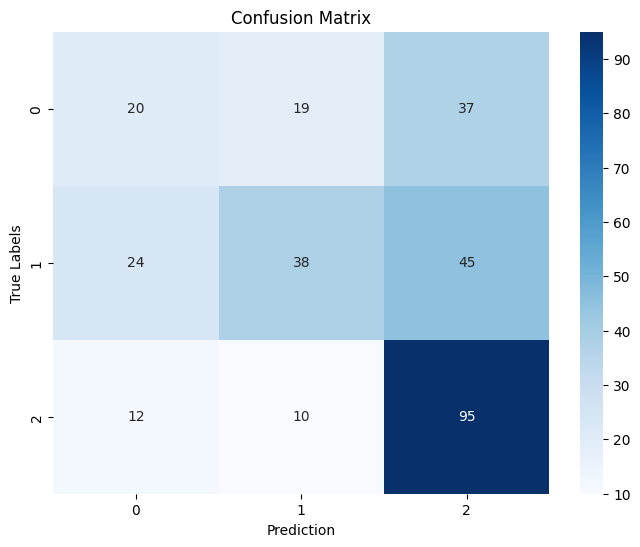

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_fill.predict(X_dev_fill)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_dev_fill, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Labels")
plt.show()

In [28]:
# Compute Precision, Recall, and F1-score (in mean macro)
precision = precision_score(y_dev_fill, y_pred_classes, average='macro')
recall = recall_score(y_dev_fill, y_pred_classes, average='macro')
f1 = f1_score(y_dev_fill, y_pred_classes, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# More complete informations
print("\n")
print(classification_report(y_dev_fill, y_pred_classes))


Precision : 0.4870
Recall : 0.4768
F1 Score : 0.4620


              precision    recall  f1-score   support

           0       0.36      0.26      0.30        76
           1       0.57      0.36      0.44       107
           2       0.54      0.81      0.65       117

    accuracy                           0.51       300
   macro avg       0.49      0.48      0.46       300
weighted avg       0.50      0.51      0.48       300



In [29]:
model_without_na = build_a_model()

# Normalisation so that the fitting of the CNN is easier
X_train_without_na= np.stack(train_df_images_without_na['image'].to_numpy()).astype('float32') / 255.0
y_train_without_na = train_df_images_without_na['label']

# Normalisation so that the fitting of the CNN is easier
X_dev_without_na = np.stack(dev_df_images_without_na['image'].to_numpy()).astype('float32') / 255.0
y_dev_without_na = dev_df_images_without_na['label']

model_without_na.fit(X_train_without_na, y_train_without_na, epochs=40, batch_size=32)

# Evaluation, on both sets
train_loss, train_accuracy = model_without_na.evaluate(X_train_without_na, y_train_without_na)
dev_loss, dev_accuracy = model_without_na.evaluate(X_dev_without_na, y_dev_without_na)

print(f"Accuracy on the train set : {train_accuracy:.4f}")
print(f"Accuracy on the dev set : {dev_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.4478 - loss: 1.2611
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.4941 - loss: 0.9873
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5097 - loss: 1.0033
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.5307 - loss: 0.9754
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5282 - loss: 0.9635
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5700 - loss: 0.9193
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5284 - loss: 0.9440
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5908 - loss: 0.8846
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5892 - loss: 0.9221
Epoch 10/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6122 - loss: 0.8463
Epoch 11/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6499 - loss: 0.8245
Epoch 12/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accurac

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


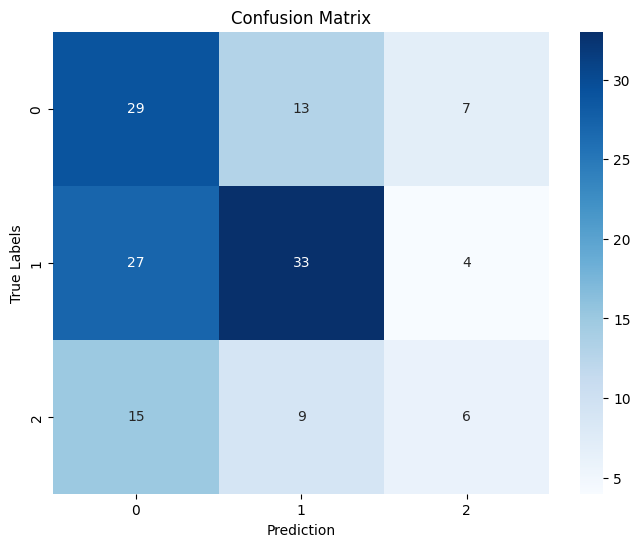

In [30]:
y_pred = model_without_na.predict(X_dev_without_na)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_dev_without_na, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Labels")
plt.show()

In [31]:
# 2. Compute Precision, Recall, and F1-score (in mean macro)
precision = precision_score(y_dev_without_na, y_pred_classes, average='macro')
recall = recall_score(y_dev_without_na, y_pred_classes, average='macro')
f1 = f1_score(y_dev_without_na, y_pred_classes, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 3. More complete informations
print("\n")
print(classification_report(y_dev_without_na, y_pred_classes))

Precision : 0.4538
Recall : 0.4358
F1 Score : 0.4311


              precision    recall  f1-score   support

           0       0.41      0.59      0.48        49
           1       0.60      0.52      0.55        64
           2       0.35      0.20      0.26        30

    accuracy                           0.48       143
   macro avg       0.45      0.44      0.43       143
weighted avg       0.48      0.48      0.47       143

